In [1]:
# project: p5
# submitter: tjbuck
# partner: none
# hours: 20

In [2]:
from zipfile import ZipFile, ZIP_DEFLATED
import zipfile
import pandas as pd
import re
import operator
import geopandas as gpd
from graphviz import Graph, Digraph
from shapely.geometry import Polygon, box, Point
from matplotlib import cm
import matplotlib.pyplot as plt
from io import TextIOWrapper

In [3]:
#Q1: what's the total size in bytes of the files requested?

with ZipFile("server_log.zip") as zf:
    for name in zf.infolist():
        with zf.open(name) as csvfile:
            df = pd.read_csv(csvfile)

size = 0
for num in df["size"]:
    size += num
int(size)

24801002666

In [4]:
#Q2: how many filings have been accessed by the top ten IPs?

total_list = df.groupby(by = "ip").count()["date"]
most_visited = total_list.sort_values()[-10:].to_dict()

most_visited

{'82.13.163.caf': 3527,
 '217.174.255.dgd': 3551,
 '208.77.214.jeh': 3806,
 '208.77.215.jeh': 3903,
 '103.238.106.gif': 4428,
 '204.212.175.bch': 4708,
 '68.180.231.abf': 5493,
 '52.45.218.ihf': 5562,
 '183.195.251.hah': 6524,
 '54.152.17.ccg': 12562}

In [5]:
#Q3: what fraction of the time do errors occur?

error_count = 0
for code in df["code"]:
    if code >= 400.0:
        error_count += 1

error_count/len(df.index)

0.03466852724527611

In [6]:
#Q4: what is the most frequently accessed file?

dict_file = df.groupby(by = ["cik", "accession", "extention"]).count()["ip"].sort_values()[-1:].to_dict()
item_list = [item for i in list(dict_file.keys()) for item in i]
item_list[0] = str(int(item_list[0]))
"/".join(item_list)

'1627631/0001627631-15-000004/.txt'

In [7]:
#Q5: how many requests were made by automated crawlers?

crawler_count = 0
for val in df["crawler"]:
    if val != 0.0:
        crawler_count += 1

crawler_count
        

971

In [8]:
import edgar_utils
from edgar_utils import lookup_region
%load_ext autoreload
%autoreload 2

In [9]:
#Q6: which region uses EDGAR most heavily?
volume_dict = {}
ip_visited1 = []
for ip in df["ip"]:
    if ip in ip_visited1:
        continue
    else: 
        ip_visited1.append(ip)
    region = lookup_region(ip) 
    if region in volume_dict:
        volume_dict[region] += 1
    else:
        volume_dict[region] = 1

sorted_tuples_q6 = sorted(volume_dict.items(), key=operator.itemgetter(1)) # #https://stackabuse.com/how-to-sort-dictionary-by-value-in-python/
sorted_dict_q6 = {k: v for k, v in sorted_tuples_q6}
list(sorted_dict_q6)[-1]

'United States of America'

In [10]:
#Q7: what fraction of IPs in each region are high-volume users?

ip_group = df.groupby(by="ip").count()
highuser_list = []
for ip in ip_group[ip_group["date"]>=1000].index:
    highuser_list.append(ip)

high_volume_dict = {}
ip_visited = []
for ip in df["ip"]:
    if ip not in ip_visited:
        ip_visited.append(ip)
    else:
        continue
    region = lookup_region(ip) 
    if region in high_volume_dict:
        if ip in highuser_list:
            high_volume_dict[region] += 1
    elif region not in high_volume_dict:
        if ip in highuser_list:
            high_volume_dict[region] = 1
        else:
            high_volume_dict[region] = 0
            
final_dict = {x:float(high_volume_dict[x])/volume_dict[x] for x in volume_dict} # https://stackoverflow.com/questions/11840111/divide-the-values-of-two-dictionaries-in-python

final_dict

{'United States of America': 0.019862490450725745,
 'China': 0.006864988558352402,
 'Hong Kong': 0.0,
 'Ireland': 0.3125,
 'Canada': 0.017857142857142856,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'Czechia': 0.0,
 'Germany': 0.0,
 'Bulgaria': 0.3333333333333333,
 'France': 0.0036900369003690036,
 'India': 0.058823529411764705,
 'Korea (Republic of)': 0.2,
 'Australia': 0.07692307692307693,
 'Spain': 0.0,
 'Netherlands': 0.0,
 'Sweden': 0.0,
 'Sudan': 0.0,
 'Estonia': 0.0,
 'Russian Federation': 0.0,
 'Tanzania, United Republic of': 0.0,
 'Yemen': 0.0,
 'Algeria': 0.0,
 'Ukraine': 0.0,
 'Slovakia': 0.0,
 'Viet Nam': 0.0,
 'Denmark': 0.0,
 'Singapore': 0.0,
 'Switzerland': 0.0,
 'Thailand': 0.0,
 'South Africa': 0.0,
 'Italy': 0.0,
 'Poland': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Brazil': 0.0,
 'Morocco': 0.0,
 'Malaysia': 0.0,
 'Hungary': 0.0,
 'Japan': 0.0,
 'Luxembourg': 0.0,
 'Romania': 0.0,
 'Liberia': 0.0,
 'Israel': 0.0,
 'Bangladesh': 0.0

In [11]:
#Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?

file_dict = {}
with ZipFile("docs.zip") as zf:
    for name in zf.infolist():
        with zf.open(name) as file:
            name = re.findall(r"filename='(.*?)'", str(name))[0]
            z = TextIOWrapper(file)
            file_dict[name] = edgar_utils.Filing(z.read()) 
        
file_dict["850693/0000850693-07-000159/-index.htm"].dates

['2007-07-25', '2007-07-25', '2007-07-23']

In [12]:
#Q9: what is the distribution of states for the filings in docs.zip?
state_dict = {}
for item in file_dict.values():
    state = item.state()
    if state == None:
        continue
    if state in state_dict:
        state_dict[state] += 1
    else:
        state_dict[state] = 1

sorted_tuples_q9 = sorted(state_dict.items(), key=operator.itemgetter(1), reverse = True) # https://stackabuse.com/how-to-sort-dictionary-by-value-in-python/
sorted_dict_q9 = {k: v for k, v in sorted_tuples_q9}
sorted_dict_q9

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'CO': 25,
 'IL': 25,
 'PA': 25,
 'NJ': 23,
 'FL': 21,
 'VA': 15,
 'MN': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'NC': 9,
 'WI': 9,
 'GA': 8,
 'OK': 7,
 'OX': 6,
 'NV': 6,
 'IA': 6,
 'UT': 5,
 'KS': 5,
 'AZ': 5,
 'IN': 4,
 'TN': 4,
 'MO': 4,
 'WA': 3,
 'KY': 2,
 'NE': 2,
 'LA': 2,
 'OR': 2,
 'WV': 2,
 'MS': 1,
 'AL': 1,
 'SD': 1,
 'NM': 1,
 'AR': 1,
 'VT': 1,
 'ID': 1,
 'DC': 1,
 'ME': 1}

In [13]:
#Q10: what is the distribution of SIC codes for the filings in docs.zip?

sic_dict = {}
for item in file_dict.values():
    sic = item.sic
    if sic == None:
        continue
    if sic in sic_dict:
        sic_dict[sic] += 1
    else:
        sic_dict[sic] = 1

sorted_tuples_q10 = sorted(sic_dict.items(), key=operator.itemgetter(1), reverse = True) # https://stackabuse.com/how-to-sort-dictionary-by-value-in-python/
sorted_dict_q10 = {k: v for k, v in sorted_tuples_q10}
sorted_dict_q10

{2834: 40,
 6022: 20,
 1311: 20,
 6798: 20,
 6021: 20,
 1389: 19,
 6189: 17,
 6211: 17,
 2836: 13,
 7389: 11,
 1000: 11,
 7372: 11,
 6029: 11,
 6331: 10,
 6199: 8,
 4911: 8,
 2860: 8,
 6282: 8,
 7370: 7,
 3841: 6,
 7371: 6,
 3674: 5,
 4931: 5,
 1700: 5,
 4522: 5,
 8742: 5,
 900: 5,
 3826: 5,
 7374: 4,
 2510: 4,
 6035: 4,
 4813: 4,
 3842: 4,
 3663: 4,
 5812: 4,
 3620: 3,
 6221: 3,
 3829: 3,
 6799: 3,
 3420: 3,
 3510: 3,
 8062: 3,
 1400: 3,
 3576: 3,
 2800: 3,
 7200: 3,
 7373: 3,
 8731: 2,
 1040: 2,
 2810: 2,
 3990: 2,
 5940: 2,
 1731: 2,
 6311: 2,
 8082: 2,
 6324: 2,
 6321: 2,
 3845: 2,
 1221: 2,
 3669: 2,
 5900: 2,
 5500: 2,
 4841: 2,
 8711: 2,
 5172: 2,
 1382: 2,
 7812: 2,
 4922: 2,
 3679: 2,
 3621: 2,
 5122: 2,
 3661: 2,
 3577: 2,
 6141: 2,
 3272: 2,
 3695: 2,
 3559: 2,
 3690: 2,
 2111: 2,
 3825: 2,
 1531: 2,
 2870: 2,
 4812: 2,
 5065: 2,
 7900: 2,
 5661: 2,
 4512: 2,
 7830: 2,
 3571: 1,
 7361: 1,
 3140: 1,
 6200: 1,
 7381: 1,
 4941: 1,
 5621: 1,
 7330: 1,
 8051: 1,
 3550: 1,
 2890: 

In [14]:
name_list = []
for row in df.itertuples():
    name = str(int(row.cik))+"/"+ row.accession+ "/" + row.extention
    name_list.append(name)

In [15]:
#Q11: what is the distribution of requests across industries?

sic_requests = {}
for item in name_list:
    if item in list(file_dict.keys()):
        sic = file_dict[item].sic
        if sic == None:
            continue
        if sic in sic_requests:
            sic_requests[sic] += 1
        else:
            sic_requests[sic] = 1

sorted_tuples_q11 = sorted(sic_requests.items(), key=operator.itemgetter(1), reverse = True) # https://stackabuse.com/how-to-sort-dictionary-by-value-in-python/
sorted_dict_q11 = {k: v for k, v in sorted_tuples_q11}
sorted_dict_q11

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 

In [16]:
#Q12: how many requests were made in each hour?

hour_dict = {}
for time in df["time"]:
    hour = int(time[:2])
    if hour in hour_dict:
        hour_dict[hour] += 1
    else:
        hour_dict[hour] = 1
hour_dict

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

In [17]:
big_dict = {"Australia":set(), "France":set(), "Viet Nam":set()}
for row in df.itertuples():
    region = lookup_region(row.ip)
    if region == "Australia" or region == "France" or region == "Viet Nam":
        name = str(int(row.cik))+"/"+ row.accession+ "/" + row.extention 
        if name in file_dict.keys():
            big_dict[region].add(file_dict[name].state())
        else:
            continue

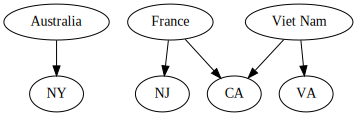

In [18]:
#Q13: what is the geographic overlap in interest between Australia, France, and Viet Nam?
            
g = Digraph()
for k,v in big_dict.items():
    for value in v:
        g.edge(k,value)
g

In [19]:
#Q14: what are the most commonly seen street addresses?

address_dict = {}
for name in name_list:
    if name in list(file_dict.keys()):
        for address in file_dict[name].addresses:
            if address in address_dict:
                address_dict[address] += 1
            else:
                address_dict[address] = 1
address_final = dict((k, v) for k, v in address_dict.items() if v >= 225 ) # https://stackoverflow.com/questions/18807079/selecting-elements-of-a-python-dictionary-greater-than-a-certain-value
address_final

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277}

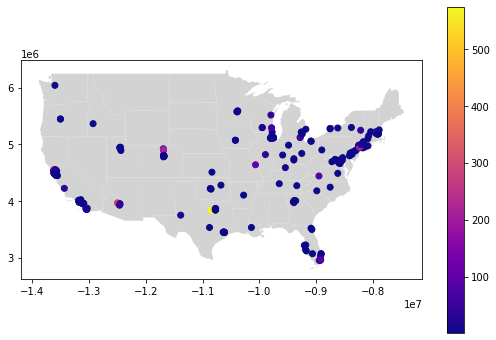

In [20]:
#Q15: geographic plotting of headquarters

background = gpd.read_file("shapes/cb_2018_us_state_20m.shp")
us_main = box(-130, 50, -55, 20)
us = background.intersection(us_main)
us = us[~us.is_empty].to_crs("epsg:3395")


hdq = gpd.read_file("locations.geojson").to_crs(us.crs)
count_list = []
for address in hdq["address"]:
    if address in address_dict.keys():
        count_list.append(address_dict[address])
    else:
        continue
hdq["count"] = count_list

hdq = hdq[hdq.intersects(us.unary_union)]
ax = us.plot(color="lightgray", figsize=(9,6))
hdq.plot(ax=ax, column= "count", legend = True, cmap = "plasma", vmin = 1, vmax = 575)
ax.set_yticks([3*1e6, 4*1e6, 5*1e6, 6*1e6])